In [145]:
import requests 
from bs4 import BeautifulSoup as bs
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from konlpy.tag import Okt
from wordcloud import WordCloud
import numpy as np
from review_tokenize import df_tokenize
from sklearn.decomposition import LatentDirichletAllocation
import json
from os.path import join
from gensim.models import Word2Vec


In [21]:
# 검색 결과에 따른 url 링크 저장

urls = []
# url 변화하는거 적당히 보고 알아서 잘 해야됨. 페이지 단위로 넘어가는게 아니라면 selenium 써야할 수도 있음.
url_head = "https://news.joins.com/Search/JoongangNews?page="
url_tail = "&Keyword=kaist&SortType=New&ScopeType=TitleContent&SearchCategoryType=JoongangNews"
for page in range(1,150):
    url_final = url_head + str(page) + url_tail
    response = requests.get(url_final)
    html = response.content
    soup = bs(html, "html.parser")
    elements = soup.select('.thumb a[href]') # F12 눌러서 적당히 우리가 원하는 a href 태그 url 링크 달려있는 id 또는 class 찾아서 넣어주면 됨. 
    for element in elements:
      link = element.attrs['href']
      urls.append(link)
print('Whole post num : {}'.format(len(urls)))

10
20
30
40
50
60
70
80
90
100
110
120
130
140
Whole post num : 1300


In [22]:
# 기사 내용 긁어오기
titles = []
contents = []
for i,url in enumerate(urls):
    response = requests.get(url)
    html = response.text
    soup = bs(html,'html.parser')
    try: 
        content = soup.select('#article_body')[0].get_text() # select 안에 본문에 해당하는 id 값을 찾아서 넣어주면 됨.
        content = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', content)
        title = soup.select('#article_title')[0].get_text()
    except: 
        print(content,title)
    contents.append(content)
    titles.append(title)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [30]:
data = {"title" : titles,"content": contents,"url": urls}
df = pd.DataFrame(data)
df['content'] =df['content'].map(lambda x : x.replace('\r',""))
df.head()

,title,content,url
0,[심현철의 미래를 묻다] 조종사 없는 수송기·여객기 늦어도 10년 뒤 날아다닌다,무인 항공기의 세계 심현철 KAIST 전기및전자공학부 교수 ...,https://news.joins.com/article/23897312
1,젊어진 ‘뉴 한화’…그룹 지원 총괄에 권혁웅 사장,김동관 한화그룹이 그룹 내 종합 케미칼·에너지 기업인 한화...,https://news.joins.com/article/23894686
2,코로나만 죽이고 인체 무해한 '마법의 물방울'…국내서 개발,초미세 물방울이 대량으로 정전분무되는 모습[자료 KAIST] ...,https://news.joins.com/article/23894084
3,[단독] 한화 지원총괄에 권혁웅…'뉴 한화' 살림 전반 살펴,한화그룹이 그룹 내 종합 케미칼ㆍ에너지 기업인 한화토탈의 권혁웅(59ㆍ사장)...,https://news.joins.com/article/23893745
4,"KAIST-KIST, 수소생산 효율 20배 높인 3차원 촉매소재 개발",KAIST-KIST 공동연구팀이 물을 전기분해해 수소를 생산할 때 쓰는 고효...,https://news.joins.com/article/23889868


In [32]:
df.to_pickle("joongang_posts.pkl")

In [2]:
df=pd.read_pickle("joongang_posts.pkl")
df.head()

,title,content,url
0,[심현철의 미래를 묻다] 조종사 없는 수송기·여객기 늦어도 10년 뒤 날아다닌다,무인 항공기의 세계 심현철 KAIST 전기및전자공학부 교수 ...,https://news.joins.com/article/23897312
1,젊어진 ‘뉴 한화’…그룹 지원 총괄에 권혁웅 사장,김동관 한화그룹이 그룹 내 종합 케미칼·에너지 기업인 한화...,https://news.joins.com/article/23894686
2,코로나만 죽이고 인체 무해한 '마법의 물방울'…국내서 개발,초미세 물방울이 대량으로 정전분무되는 모습[자료 KAIST] ...,https://news.joins.com/article/23894084
3,[단독] 한화 지원총괄에 권혁웅…'뉴 한화' 살림 전반 살펴,한화그룹이 그룹 내 종합 케미칼ㆍ에너지 기업인 한화토탈의 권혁웅(59ㆍ사장)...,https://news.joins.com/article/23893745
4,"KAIST-KIST, 수소생산 효율 20배 높인 3차원 촉매소재 개발",KAIST-KIST 공동연구팀이 물을 전기분해해 수소를 생산할 때 쓰는 고효...,https://news.joins.com/article/23889868


In [67]:
def remove_oneword(targets):
    result = []
    for a in targets: 
        if len(a) != 1:
            result.append(a)
    return result

In [155]:
##version nori 
def tokenizeNpostprocess(df):
    df=df_tokenize(df)
    df['content_token']=df['content_token'].map(lambda x: remove_oneword(x))
    df['title_token']=df['title_token'].map(lambda x: remove_oneword(x))
    return df

df.head()

,title,content,url,title_token,content_token
0,[심현철의 미래를 묻다] 조종사 없는 수송기·여객기 늦어도 10년 뒤 날아다닌다,무인 항공기의 세계 심현철 KAIST 전기및전자공학부 교수 ...,https://news.joins.com/article/23897312,"[무인, 항공기, 세계, 심현철, KAIST, 전기, 전자, 공학부, 교수, 영국,...","[심현철, 미래, 묻다, 조종사, 없다, 수송기, 여객기, 늦다, 날아다니다]"
1,젊어진 ‘뉴 한화’…그룹 지원 총괄에 권혁웅 사장,김동관 한화그룹이 그룹 내 종합 케미칼·에너지 기업인 한화...,https://news.joins.com/article/23894686,"[김동관, 한화그룹, 그룹, 종합, 케미, 에너지, 기업, 한화, 토탈, 권혁웅, ...","[젊다, 한화, 그룹, 지원, 총괄, 권혁웅, 사장]"
2,코로나만 죽이고 인체 무해한 '마법의 물방울'…국내서 개발,초미세 물방울이 대량으로 정전분무되는 모습[자료 KAIST] ...,https://news.joins.com/article/23894084,"[초미세, 물방울, 대량, 정전, 분무, 모습, 자료, KAIST, 신종, 코로나,...","[코로나, 죽이다, 인체, 무해하다, 마법, 물방울, 국내, 개발]"
3,[단독] 한화 지원총괄에 권혁웅…'뉴 한화' 살림 전반 살펴,한화그룹이 그룹 내 종합 케미칼ㆍ에너지 기업인 한화토탈의 권혁웅(59ㆍ사장)...,https://news.joins.com/article/23893745,"[한화그룹, 그룹, 종합, 케미, 에너지, 기업, 한화, 토탈, 권혁웅, 사장, 대...","[단독, 한화, 지원, 총괄, 권혁웅, 한화, 살림, 전반, 살피다]"
4,"KAIST-KIST, 수소생산 효율 20배 높인 3차원 촉매소재 개발",KAIST-KIST 공동연구팀이 물을 전기분해해 수소를 생산할 때 쓰는 고효...,https://news.joins.com/article/23889868,"[KAIST, KIST, 공동, 연구, 전기, 분해, 수소, 생산, 쓸다, 효율, ...","[KAIST, KIST, 수소, 생산, 효율, 높이다, 차원, 촉매, 소재, 개발]"


In [7]:
def identity_tokenizer(text):
    """
    sklearn의 Tfidfvectorizer를 이용함에 있어서 우리의 nori 토크나이저가 토큰화 한 결과를 사용하기 위한 method이다.

    :param text: 토큰화 하고자 하는 문장
    :return: 토큰이 담긴 리스트가 반환된다.
    """
    list1 = text.split('00')
    return list1

In [8]:
def TfidfWord(df):
    #TF-IDF를 기반으로 카이스트 검색시 가장 의미가 높은 단어로 예상되는 단어 100가지를 추출함.

    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                                    max_features=100,
                                    max_df=0.5,
                                    ngram_range=(1, 1))

    # content를 기반으로 TF-IDF를 돌리는 함수
    words_list_content = []
    token_concat = df['content_token'].map(lambda x: "00".join(x))
    tfidf_matrix = vectorizer.fit_transform(token_concat)
    tfidf_wordslist = vectorizer.get_feature_names()
    vocab = dict()
    for idx, word in enumerate(tfidf_wordslist):
        vocab[word] = tfidf_matrix.getcol(idx).sum()
    words_list_content = sorted(vocab.items(), key=lambda x: x[1], reverse=True)


    # title을 기반으로 TF-IDF를 돌리는 함수
    words_list_title = []
    token_concat = df['title_token'].map(lambda x: "00".join(x))
    tfidf_matrix = vectorizer.fit_transform(token_concat)
    tfidf_wordslist = vectorizer.get_feature_names()
    vocab = dict()
    for idx, word in enumerate(tfidf_wordslist):
        vocab[word] = tfidf_matrix.getcol(idx).sum()
    words_list_title = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

    return words_list_content, words_list_title

In [9]:
def CountWord(df):
    #단어가 나온 빈도수를 기반으로 카이스트 검색시 가장 의미가 높은 단어로 예상되는 단어 100가지를 추출함.

    vectorizer = CountVectorizer(tokenizer=identity_tokenizer,
                                    max_features=100,
                                    max_df=0.5,
                                    ngram_range=(1, 1))

    # content를 기반으로 TF-IDF를 돌리는 함수
    words_list_content = []
    token_concat = df['content_token'].map(lambda x: "00".join(x))
    tfidf_matrix = vectorizer.fit_transform(token_concat)
    tfidf_wordslist = vectorizer.get_feature_names()
    vocab = dict()
    for idx, word in enumerate(tfidf_wordslist):
        vocab[word] = tfidf_matrix.getcol(idx).sum()
    words_list_content = sorted(vocab.items(), key=lambda x: x[1], reverse=True)


    # title을 기반으로 를 돌리는 함수
    words_list_title = []
    token_concat = df['title_token'].map(lambda x: "00".join(x))
    tfidf_matrix = vectorizer.fit_transform(token_concat)
    tfidf_wordslist = vectorizer.get_feature_names()
    vocab = dict()
    for idx, word in enumerate(tfidf_wordslist):
        vocab[word] = tfidf_matrix.getcol(idx).sum()
    words_list_title = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

    return words_list_content, words_list_title

In [139]:
def topic_modeling(df,n):
    vectorizer = CountVectorizer(tokenizer=identity_tokenizer,
                                max_features=300,
                                max_df=0.5,
                                ngram_range=(1, 1))
    token_concat = df['content_token'].map(lambda x: "00".join(x)) + df['title_token'].map(lambda x: "00".join(x))
    X=vectorizer.fit_transform(token_concat)
    lda_model=LatentDirichletAllocation(n_components=20,learning_method='online',random_state=777,max_iter=1)
    lda_top=lda_model.fit_transform(X)
    terms = vectorizer.get_feature_names() 
    topic_dict = get_topics(lda_model.components_,terms,n)    
    return topic_dict

def get_topics(components, feature_names, n=5):
    topic_dict = dict()
    for idx, topic in enumerate(components):
        topic_dict[str(idx+1)] = [{'feature_name' : feature_names[i], 'topic_coefficient': topic[i].round(2)} for i in topic.argsort()[:-n - 1:-1]]
    return topic_dict

In [143]:
topic = topic_modeling(df,10)

In [159]:
def find_cooccur(tokens,target,window,num):
    cooccur_dict = dict()
    for token in tokens:
        indices = [i for i, x in enumerate(token) if x.lower() == target.lower()]
        if len(indices)!=0:
            for indice in indices:
                for i in np.arange(indice-window,indice+window):
                    if i>=0 and i<=len(token)-1:
                        if token[i] in cooccur_dict.keys() :
                            cooccur_dict[token[i]] += 1
                        else :
                            cooccur_dict[token[i]] = 1 
    try :
        del cooccur_dict[target]
    except KeyError:
        del cooccur_dict[target.upper()]
    return sorted(cooccur_dict.items(),key=lambda item:item[1],reverse=True)[:num]

        

In [160]:
titles_token=df['title_token'].tolist()
contents_token=df['content_token'].tolist()
tokens = titles_token + contents_token

find_cooccur(tokens,'ai',2,20)

[('인공지능', 230),
 ('기술', 73),
 ('대학원', 64),
 ('연구', 59),
 ('데이터', 54),
 ('하다', 48),
 ('로봇', 47),
 ('인재', 44),
 ('개발', 39),
 ('분야', 35),
 ('있다', 34),
 ('기반', 32),
 ('시대', 30),
 ('되다', 29),
 ('산업', 27),
 ('국내', 26),
 ('인간', 26),
 ('한국', 26),
 ('KAIST', 25),
 ('위하다', 24)]

In [158]:
model = Word2Vec(sentences=tokens,size=300,window=5,min_count=3,workers=4, sg=0)
model.similar_by_word('AI')

C:\Users\user\anaconda3\envs\pytorch-CycleGAN-and-pix2pix\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('인공지능', 0.9257215857505798),
 ('성창모', 0.8208544254302979),
 ('코어', 0.8122588396072388),
 ('IoT', 0.797178328037262),
 ('프린팅', 0.7933342456817627),
 ('클라우드', 0.7914063334465027),
 ('러닝', 0.7910709977149963),
 ('지능', 0.7894772291183472),
 ('개척', 0.7860508561134338),
 ('미래형', 0.7824482321739197)]

In [10]:
TF_content_word, TF_title_word= TfidfWord(df)
Count_content_word, Count_title_word= CountWord(df)

In [115]:
def stopwords_remove(dict):
    stopwords  = ['kaist','교수']
    for stopword in stopwords:
        try:
            del dict[stopword]
        except KeyError:
            continue
    return dict 

In [116]:
def word_tuple2dict(tups):
    target_dict =dict((x,int(y)) for x,y in tups)
    for key in list(target_dict.keys()):
        if len(key) ==1 :
           del target_dict[key]
    return target_dict

In [117]:
print('==================TF_CONTENT=============\n')
TF_content_word_dict=word_tuple2dict(TF_content_word[:50])
TF_content_word_dict = stopwords_remove(TF_content_word_dict)
print(TF_content_word_dict)
print('==================TF_title=============\n')
TF_title_word_dict=word_tuple2dict(TF_title_word[:50])
TF_title_word_dict = stopwords_remove(TF_title_word_dict)
print(TF_title_word_dict)
print('==================Count_CONTENT=============\n')
Count_content_word_dict=word_tuple2dict(Count_content_word[:50])
Count_content_word_dict = stopwords_remove(Count_content_word_dict)
print(Count_content_word_dict)
print('==================Count_title=============\n')
Count_title_word_dict=word_tuple2dict(Count_title_word[:50])
Count_title_word_dict = stopwords_remove(Count_title_word_dict)
print(Count_title_word_dict)

==================TF_CONTENT=============

{'한국': 57, '대학': 46, '기술': 37, 'ai': 36, '과학': 34, '세계': 30, '로봇': 30, '인공지능': 27, '평가': 25, '산업': 25, '만들다': 25, '경제': 24, '단독': 23, '없다': 23, '미래': 22, '기업': 22, '시대': 22, '총장': 22, '개발': 22, '되다': 21, '하다': 20, '연구': 19, '대전': 19, '코로나': 18, '보다': 18, '정부': 17, '혁신': 17, '논문': 17, '국내': 17, '인재': 16, '받다': 16, '있다': 16, '사람': 16, '교육': 16, '혁명': 16, '반도체': 15, '가다': 15, '삼성': 15, '원전': 14}
==================TF_title=============

{'대학': 118, '과학': 113, '기업': 90, '학생': 82, '산업': 77, '대표': 72, '정부': 68, '세계': 67, '교육': 66, '미국': 63, '공학': 62, '인공지능': 61, '평가': 61, '총장': 60, '사회': 60, '만들다': 59, '시장': 59, 'ai': 58, '사진': 57, '미래': 55, '정보': 54, '로봇': 54, '경제': 54, '분야': 53, '사업': 53, '국내': 53, '지원': 52, '박사': 52, '사람': 51, '밝히다': 51, '서울': 50, '보다': 50, '대전': 50, '논문': 49, '많다': 48, '창업': 48, '우리': 47, '가능': 47, '정책': 46, '과정': 46, '문제': 46, '따르다': 46}
==================Count_CONTENT=============

{'한국': 117, '대학': 109, '기술': 75, '과학': 69, '인공

In [161]:
def analyze_korean(df,root_path,topic_num=10,keyword_num=50,topn=10):
    df =tokenizeNpostprocess(df)
    #keyword extract part
    # TF_content_word, TF_title_word= TfidfWord(df)
    # Count_content_word, Count_title_word= CountWord(df)
    # TF_content_word_dict=word_tuple2dict(TF_content_word[:keyword_num])
    # TF_content_word_dict = stopwords_remove(TF_content_word_dict)
    # TF_title_word_dict=word_tuple2dict(TF_title_word[:keyword_num])
    # TF_title_word_dict = stopwords_remove(TF_title_word_dict)
    Count_content_word_dict=word_tuple2dict(Count_content_word[:keyword_num])
    Count_content_word_dict = stopwords_remove(Count_content_word_dict)
    Count_title_word_dict=word_tuple2dict(Count_title_word[:keyword_num])
    Count_title_word_dict = stopwords_remove(Count_title_word_dict)

    dict_list = [Count_content_word_dict,Count_title_word_dict]

    #topic modeling part
    topic=topic_modeling(df,topic_num)
    with open(join(root_path,'topic.json'), 'w', encoding='UTF-8-sig') as file:
        file.write(json.dumps(topic, ensure_ascii=False))
    
    titles_token=df['title_token'].tolist()
    contents_token=df['content_token'].tolist()
    tokens = titles_token + contents_token


    #window내에서 함께 나타난 다른 토큰들의 내림차순 및 유사어로 추측되는 것을 내림차순 정렬 그리고 저장
    model = Word2Vec(sentences=tokens,size=300,window=5,min_count=3,workers=4, sg=0)


    for j,method_dict in enumerate(dict_list):
        keyword_list = []
        keyword_dict = dict()
        for keyword in method_dict.keys():
            subkeyword_dict = dict()
            subkeyword_dict['keyword'] = keyword 
            subkeyword_dict['score'] = method_dict[keyword]

            tups = find_cooccur(tokens,keyword,4,topn)
            cooccur_list =[]
            for i,tup in enumerate(tups): 
                cooccur_list.append({'index':i+1, 'subkeyword':tup[0],'cooccur_num':tup[1]})
            subkeyword_dict['cooccur'] = cooccur_list
            try:
                tups = model.wv.similar_by_word(keyword,topn=topn)
            except :
                tups = model.wv.similar_by_word(keyword.upper(),topn=topn)
            similar_list =[]
            for i,tup in enumerate(tups): 
                similar_list.append({'index':i+1, 'subkeyword':tup[0],'cooccur_num':tup[1]})
            subkeyword_dict['similar'] = similar_list

            keyword_list.append(subkeyword_dict)

        for i,a in enumerate(keyword_list):
            keyword_dict[str(i+1)] = a


        if j==0:
            with open(join(root_path,'content '+'keyword.json'), 'w', encoding='UTF-8-sig') as file:
                file.write(json.dumps(keyword_dict, ensure_ascii=False))
        else:
            with open(join(root_path,'title '+'keyword.json'), 'w', encoding='UTF-8-sig') as file:
                file.write(json.dumps(keyword_dict, ensure_ascii=False))
        
analyze_korean(df,'.')
    

0 step finish
100 step finish
200 step finish
300 step finish
400 step finish
500 step finish
600 step finish
700 step finish
800 step finish
900 step finish
1000 step finish
1100 step finish
1200 step finish
0 step finish
100 step finish
200 step finish
300 step finish
400 step finish
500 step finish
600 step finish
700 step finish
800 step finish
900 step finish
1000 step finish
1100 step finish
1200 step finish
Tokenize End


In [16]:
##워드클라우드

fontpath = './font/NanumGothic.ttf'
wc = WordCloud(
    font_path= fontpath,
    width = 800,
    height = 800)
wc_tf = wc.generate_from_frequencies(TF_title_word_dict)
wc = WordCloud(
    font_path= fontpath,
    width = 800,    
    height = 800)
wc_count = wc.generate_from_frequencies(Count_title_word_dict)
array_tf =wc_tf.to_array()
array_count = wc_count.to_array()

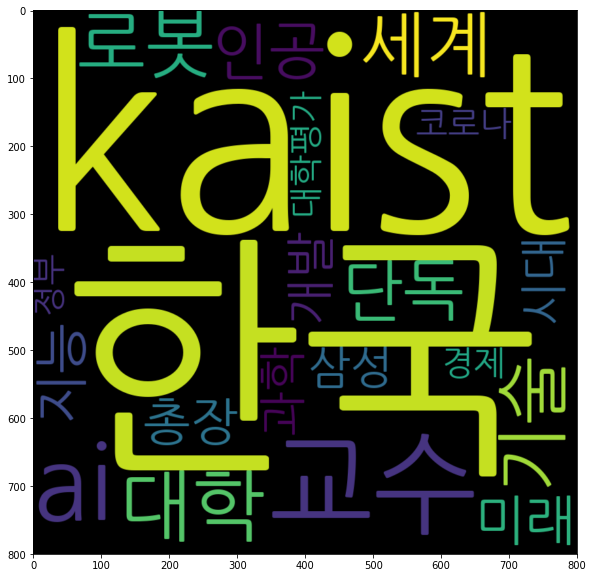

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(array_tf, interpolation="bilinear")
plt.show()
fig.savefig('./result/tf_base_wc_korean.png')


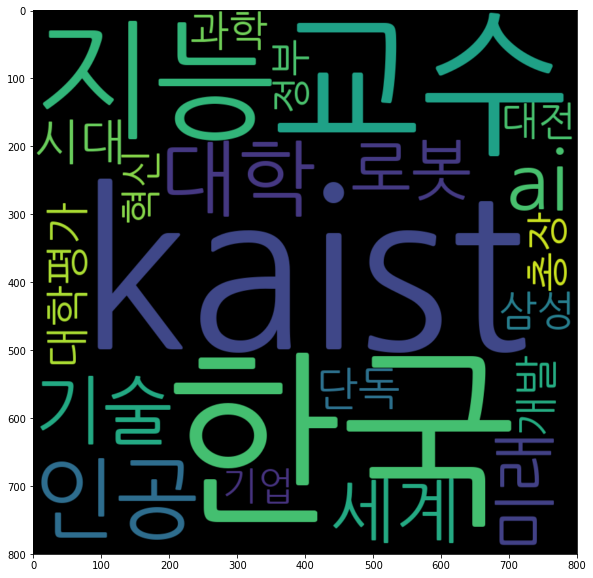

In [18]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(array_count, interpolation="bilinear")
plt.show()
fig.savefig('./result/count_base_wc_korean.png')